In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from scipy.stats import norm


In [2]:
#error-bar function

def z_fisher_error_function(y_true, y_pred, z_crit=1):
    
    r, _ = pearsonr(y_true, y_pred)
    n = len(y_true)
    
    # Fisher z-transform
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)
    
    # Intervallo al 95%
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    
    # Inversa della Fisher transform
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)
    
    print(f"r = {r:.2f} (95% CI: {r_lower:.2f} – {r_upper:.2f})")
    
    max_error_bar = r_upper-r
    min_error_bar = r-r_lower

    return max_error_bar, min_error_bar




def mae_error_function(y_true, y_pred, z_crit=1.00):

    errors = np.abs(y_true - y_pred)
    mae = np.mean(errors)
    n = len(errors)

    # stima della deviazione standard degli errori assoluti
    sigma = np.std(errors, ddof=1)
    se = sigma / np.sqrt(n)

    # intervallo di confidenza
    lower = mae - z_crit * se
    upper = mae + z_crit * se

    print(f"MAE = {mae:.3f} (CI: {lower:.3f} – {upper:.3f})")

    max_error_bar = upper - mae
    min_error_bar = mae - lower

    return max_error_bar, min_error_bar

In [30]:
def pearson_plot_results(df, min_error_bar, max_error_bar, offset_scritta = 0., error_bar_offset=0., offset_x_min=0., dataset_name='dataname'):
    # === Colors ===
    palette = ["#12908E", "#97CECC", "#F98F45", "#c4421A"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", palette, N=256)
    norm = plt.Normalize(df["Pearson"].min(), df["Pearson"].max() * 1.2)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    colors = [sm.to_rgba(val) for val in df["Pearson"]]
    
    # === Plot ===
    sns.set(style="ticks", context="talk", font_scale=0.9)
    fig, ax = plt.subplots(figsize=(7, 7))
    
    bars = ax.barh(df["Model"], df["Pearson"], color=colors)
    
    # --- Error bar for JanusDDG ---
    idx_janus = df.index[df["Model"] == "JanusDDG"][0]
    x_center = df.loc[idx_janus, "Pearson"]
    y_center = idx_janus
    
    cap_width = 0.1
    
    ax.hlines(
        y=y_center + error_bar_offset,
        xmin=x_center - min_error_bar,
        xmax=x_center + max_error_bar,
        color="black",
        linewidth=2,
        capstyle="round",
    )
    
    # Caps
    ax.vlines(
        x_center - min_error_bar,
        y_center + error_bar_offset - cap_width / 2,
        y_center + error_bar_offset + cap_width / 2,
        color="black",
        linewidth=2,
    )
    ax.vlines(
        x_center + max_error_bar,
        y_center + error_bar_offset - cap_width / 2,
        y_center + error_bar_offset + cap_width / 2,
        color="black",
        linewidth=2,
    )
    
    # --- Value labels ---
    for bar, (model, val) in zip(bars, zip(df["Model"], df["Pearson"])):
        # offset extra per JanusDDG
        extra_offset = max_error_bar if model != "JanusDDG" else max_error_bar + offset_scritta
        ax.text(val + extra_offset, bar.get_y() + bar.get_height() / 2,
                f"{val:.2f}", va="center", fontsize=13)
    
    # === Final styling ===
    ax.set_xlabel("Pearson Correlation", fontsize=18, fontweight="bold")
    ax.set_ylabel("Model", fontsize=18, fontweight="bold")
    ax.set_xlim(offset_x_min, df["Pearson"].max() + max_error_bar + 0.3)
    
    sns.despine(left=True, bottom=True)
    ax.set_title(f"{dataset_name}", fontsize=16, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


In [31]:
def mae_plot_results(df, min_error_bar, max_error_bar, error_bar_offset=0., offset_x_min=0., offset_scritta = 0., dataset_name='dataname'):
    # === Colors ===
    palette = ["#12908E", "#97CECC", "#F98F45", "#c4421A"]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", palette, N=256)
    norm = plt.Normalize(df["MAE"].min(), df["MAE"].max() * 1.2)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    colors = [sm.to_rgba(val) for val in df["MAE"]]
    
    # === Plot ===
    sns.set(style="ticks", context="talk", font_scale=0.9)
    fig, ax = plt.subplots(figsize=(7, 7))
    
    bars = ax.barh(df["Model"], df["MAE"], color=colors)
    
    # --- Error bar for JanusDDG ---
    idx_janus = df.index[df["Model"] == "JanusDDG"][0]
    x_center = df.loc[idx_janus, "MAE"]
    y_center = idx_janus
    
    cap_width = 0.1
    
    ax.hlines(
        y=y_center + error_bar_offset,
        xmin=x_center - min_error_bar,
        xmax=x_center + max_error_bar,
        color="black",
        linewidth=2,
        capstyle="round",
    )
    
    # Caps
    ax.vlines(
        x_center - min_error_bar,
        y_center + error_bar_offset - cap_width / 2,
        y_center + error_bar_offset + cap_width / 2,
        color="black",
        linewidth=2,
    )
    ax.vlines(
        x_center + max_error_bar,
        y_center + error_bar_offset - cap_width / 2,
        y_center + error_bar_offset + cap_width / 2,
        color="black",
        linewidth=2,
    )
    
    # --- Value labels ---
    for bar, (model, val) in zip(bars, zip(df["Model"], df["MAE"])):
        # offset extra per JanusDDG
        extra_offset = max_error_bar if model != "JanusDDG" else max_error_bar + offset_scritta
        ax.text(val + extra_offset, bar.get_y() + bar.get_height() / 2,
                f"{val:.2f}", va="center", fontsize=13)
    
    # === Final styling ===
    ax.set_xlabel("Mean Absolute Error (MAE)", fontsize=18, fontweight="bold")
    ax.set_ylabel("Model", fontsize=18, fontweight="bold")
    ax.set_xlim(offset_x_min, df["MAE"].max() + max_error_bar + 0.5)
    
    ax.invert_yaxis()  # mantieni ordinamento "classico" modello in alto
    
    sns.despine(left=True, bottom=True)
    ax.set_title(f"{dataset_name}", fontsize=16, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


In [47]:
def janus_plot_data(results,janus_col_name = "DDG_JanusDDG"):
    
    janus_r, _ = pearsonr(results["DDG"], results[f"{janus_col_name}"])
    janus_r = round(janus_r, 2)
    
    janus_mae = round(mean_absolute_error(results['DDG'], results[f"{janus_col_name}"]), 2)
    
    max_error_bar_mae, min_error_bar_mae = mae_error_function(
        results["DDG"], results[f"{janus_col_name}"]
    )
    
    max_error_bar_r, min_error_bar_r = z_fisher_error_function(
        results["DDG"], results[f"{janus_col_name}"]
    )

    return janus_r, janus_mae, max_error_bar_r, min_error_bar_r, max_error_bar_mae, min_error_bar_mae

In [48]:
###########################
#       PTMUL-NR         #
###########################

In [49]:
results_ptmulnr = pd.read_csv("../results/Result_Ptmul_NR.csv")

janus_r_ptmulnr, janus_mae_ptmulnr, max_error_bar_r_ptmulnr, min_error_bar_r_ptmulnr,\
max_error_bar_mae_ptmulnr, min_error_bar_mae_ptmulnr = janus_plot_data(results_ptmulnr)

# === pearson data from other papers ===
data_pearson_ptmulnr = {
    "Model": ["JanusDDG", "DDGemb", "FoldX", "MAESTRO", "DDGun", "DDGun3D"],
    "Pearson": [janus_r_ptmulnr, 0.59, 0.36, 0.28, 0.23, 0.17],
}
df_pearson_ptmulnr = pd.DataFrame(data_pearson_ptmulnr).sort_values("Pearson", ascending=False).reset_index(drop=True)

# === MAE data from other papers ===
data_mae_ptmulnr = {
    "Model": ["JanusDDG", "DDGemb", "FoldX", "MAESTRO", "DDGun", "DDGun3D"],
    "MAE": [janus_mae_ptmulnr, 1.59, 3.66, 1.88, 2.10, 2.08],
}
df_mae_ptmulnr = pd.DataFrame(data_mae_ptmulnr).sort_values("MAE").reset_index(drop=True)


MAE = 1.574 (CI: 1.426 – 1.723)
r = 0.61 (95% CI: 0.53 – 0.67)


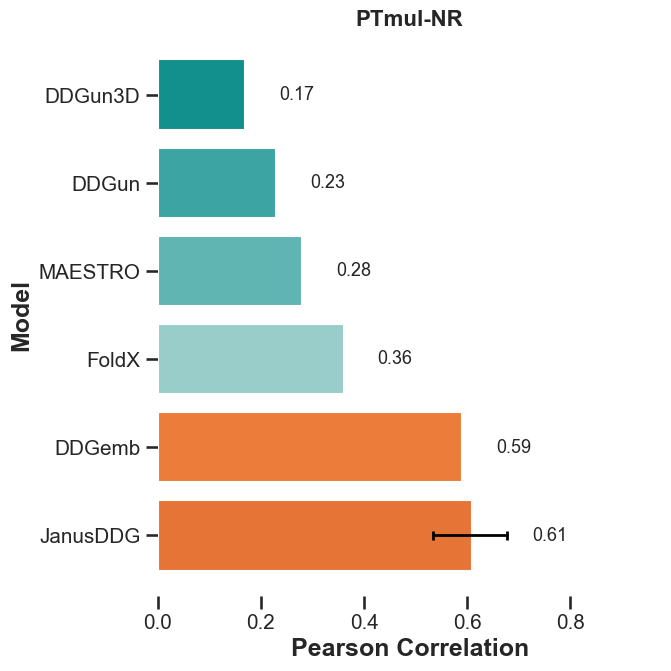

In [50]:
pearson_plot_results(df_pearson_ptmulnr, min_error_bar_r_ptmulnr, max_error_bar_r_ptmulnr, offset_scritta= 0.05,dataset_name='PTmul-NR')

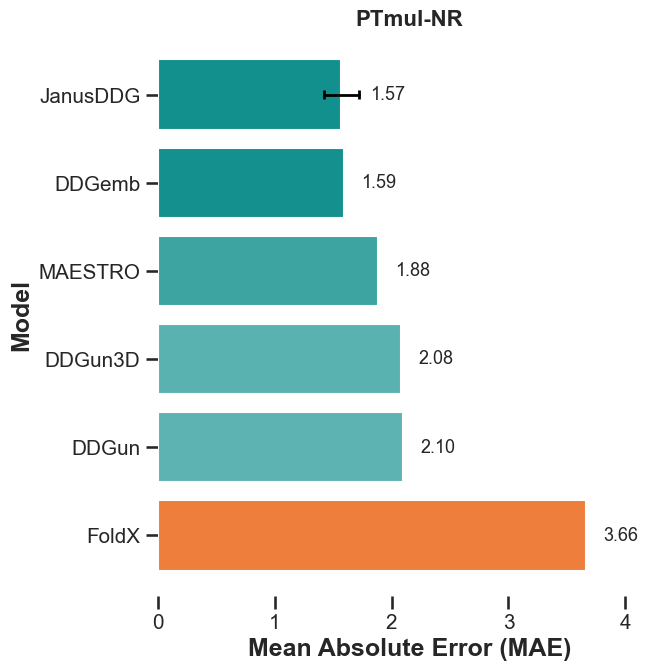

In [51]:
mae_plot_results(df_mae_ptmulnr, min_error_bar_mae_ptmulnr, max_error_bar_mae_ptmulnr, offset_scritta=  0.1,dataset_name='PTmul-NR')

In [ ]:
###########################
#          S669           #
###########################

In [52]:
results_s669 = pd.read_csv('../results/Result_s669_to_process.csv')

janus_r_s669, janus_mae_s669, max_error_bar_r_s669, min_error_bar_r_s669,\
max_error_bar_mae_s669, min_error_bar_mae_s669 = janus_plot_data(results_s669)

# === pearson data from other papers ===
data_pearson_s669 = {
    "Model": [
        'JanusDDG',"DDGemb", "PROSTATA", "ACDC-NN", "INPS-Seq", "PremPS",
        "ACDC-NN-Seq", "DDGun3D", "INPS3D", "THPLM", "ThermoNet", "DDGun", "MAESTRO",
         "Dynamut", "PoPMuSiC", "DUET", "I-Mutant3.0-Seq", "SDM", "mCSM", "Dynamut2",
        "I-Mutant3.0", "Rosetta", "FoldX", "SAAFEC-SEQ", "MUpro"
    ],
    "Pearson": [
        janus_r_s669, 0.53, 0.49, 0.46, 0.43, 0.41, 0.42, 0.43,
        0.43, 0.39, 0.39, 0.41, 0.50,
        0.41, 0.41, 0.41,
        0.34, 0.41,
        0.36, 0.34, 0.36, 0.39, 0.22, 0.36, 0.25,
    ]
}
df_pearson_s669 = pd.DataFrame(data_pearson_s669).sort_values("Pearson", ascending=False).reset_index(drop=True)

# === MAE data from other papers ===
data_mae_s669 = {
    "Model": [
        'JanusDDG',"DDGemb", "PROSTATA", "ACDC-NN", "INPS-Seq", "PremPS",
        "ACDC-NN-Seq", "DDGun3D", "INPS3D", "ThermoNet", "DDGun", "MAESTRO",
         "Dynamut", "PoPMuSiC", "DUET", "I-Mutant3.0-Seq", "SDM", "mCSM", "Dynamut2",
        "I-Mutant3.0", "Rosetta", "FoldX", "SAAFEC-SEQ", "MUpro"
    ],
    "MAE": [janus_mae_s669,
                0.99,
                1.00,
                1.05,
                1.09,1.08,1.08,
                1.11,1.07,1.17,
                1.25,1.06,1.19,
                1.09, 1.1, 1.15,
                1.26,1.13,1.15,1.12,
                2.08,1.56,1.13,1.21
    ]
}
df_mae_s669 = pd.DataFrame(data_mae_s669).sort_values("MAE").reset_index(drop=True)


MAE = 0.965 (CI: 0.927 – 1.004)
r = 0.55 (95% CI: 0.52 – 0.57)


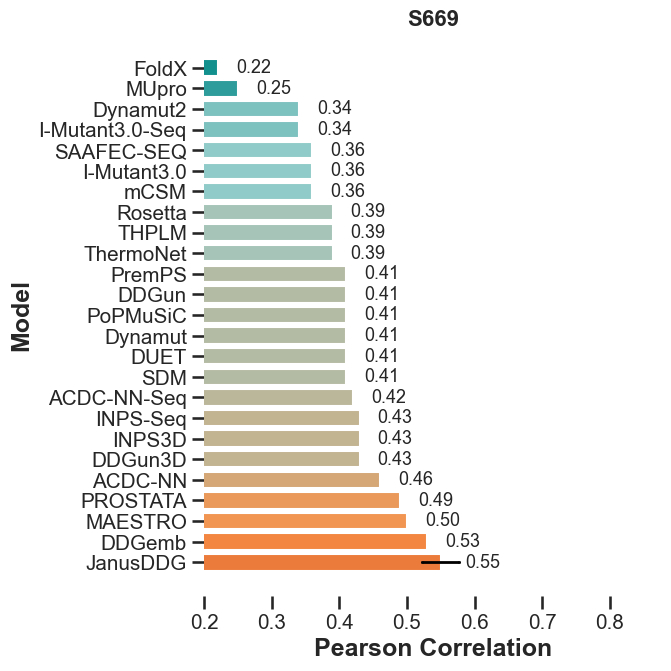

In [93]:
pearson_plot_results(df_pearson_s669, min_error_bar_r_s669, max_error_bar_r_s669, offset_scritta=0.01,offset_x_min=0.2,dataset_name = 'S669')

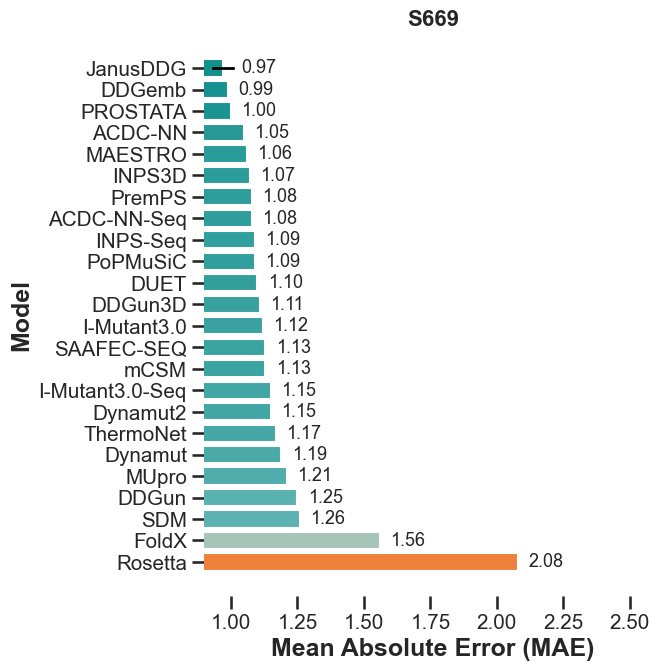

In [94]:
mae_plot_results(df_mae_s669, min_error_bar_mae_s669, max_error_bar_mae_s669, offset_scritta=0.03,offset_x_min=0.9 ,dataset_name = 'S669')

In [55]:
######################################################
# Performance computed by the data from other papers # 
######################################################

In [56]:
#OTHER DATASETS

In [103]:
#SELECT DATASET

DATASET = 'S461'

In [104]:
if DATASET == 'Ssym':
    dataset = pd.read_csv('../results/Result_ssym_analysis_dir.csv')

    Janus_results = pd.read_csv('../results/Result_ssym_analysis_dir.csv')
    columns_selected= ['JanusDDG','KORPM','mpnn_20_00','Cartddg','ACDC-NN',
               'stability-oracle','mifst','msa_transformer_mean',
               'mif','esm2_650M','ankh','tranception','esmif_multimer','DDGun3D',
               'FoldX','Evo','mutcomputex','INPS3D','esm1v_mean','ThermoNet','MAESTRO',
               'DUET','I-Mutant3.0','MUpro','mCSM','SDM','Dynamut']
    
    target_col = "DDG"

elif DATASET == 'S96':
    dataset = pd.read_csv('../results/Result_s96_test_set.csv')
    columns_selected = ['JanusDDG','DDGun', 'DDGun3D',	'INPS-MD', 'Maestro', 'mCSM', 'FoldX', 'INPS', 'POPMUSIC', 'SDM']
    target_col = "DDG"
    Janus_results = pd.read_csv('../results/Result_s96_test_set.csv')

elif DATASET == 'S461':
    dataset = pd.read_csv('../results/Result_s461_dir_analysis.csv')
    Janus_results = pd.read_csv('../results/Result_s461_dir_analysis.csv')
    columns_selected = ['JanusDDG',
     "stability-oracle_dir","CartddgD_dir","PremPS_dir","PopMusic_dir","MAESTRO_dir",
    "INPS3D_dir","DDGun3D_dir","DUET_dir","ACDC-NN_dir","KORPMD_dir","mCSM_dir",
    "SDM_dir","ThermoNet_dir","I-Mutant3.0_dir","SAAFEC-Seq_dir", "mif_dir","ankh_dir",
    "esm2_650M_dir","Dynamut_dir","mpnn_20_00_dir","esm1v_mean_dir",
    "esmif_multimer_dir","mifst_dir","mutcomputex_dir","FoldXD_dir","tranception_dir","msa_transformer_mean_dir",
    ]
    target_col = "DDG"

elif DATASET == 'Q3421':
    dataset = pd.read_csv('../data/q3421_analysis.txt')
    Janus_results = pd.read_csv('../results/Result_q3421.csv')

    columns_selected=['JanusDDG','stability-oracle_dir',
                    'K1566_pslm_rfa_2_dir',
                    'K1566_pslm_rfa_3_dir',
                    'K1566_pslm_rfa_4_dir',
                    'K1566_pslm_rfa_5_dir',
                    'K1566_pslm_rfa_6_dir',
                    'K1566_pslm_rfa_7_dir',
                  'korpm_dir', 'mutcomputex_dir','esmif_monomer_dir','esmif_multimer_dir',
                  'tranception_dir','mpnn_10_00_dir','mpnn_20_00_dir','mpnn_30_00_dir',
                  'esm2_150M_dir','mif_dir','esm1v_mean_dir','cartesian_ddg_dir','esm2_650M_dir',
                  'mifst_dir','ankh_dir','msa_transformer_mean_dir','esm2_3B_dir','esm2_15B_half_dir',
                 ]
    target_col = "ddG"

elif DATASET == 'k2369':
    dataset = pd.read_csv('../data/k2369_analysis.txt')
    Janus_results = pd.read_csv('../results/Result_k2369.csv')

    columns_selected= ['JanusDDG',
                    'stability-oracle_dir','korpm_dir','esmif_multimer_dir',
                   'tranception_dir','mpnn_10_00_dir','mpnn_20_00_dir',
                   'mpnn_30_00_dir','esm2_150M_dir','esm1v_mean_dir',
                   'esm2_650M_dir','mif_dir','cartesian_ddg_dir','msa_transformer_mean_dir',
                   'mifst_dir',
                   'ankh_dir','esm2_3B_dir',
                    'esm2_15B_half_dir'
                    ]

    target_col = "ddG"  

else:
    assert False

In [105]:
# Selezionare solo le colonne dei modelli e il valore vero (ddG_dir)
dataset['JanusDDG'] = Janus_results['DDG_JanusDDG'].values
df_selected = dataset.loc[:, columns_selected + [target_col]]#.fillna(0)

# Caompute metrics for each model
results = {}
for model in columns_selected:
    y_true = df_selected.dropna(subset=[model])[target_col]
    y_pred = df_selected.dropna(subset=[model])[model]
    
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    results[model] = {
        'Pearson': round(pearson_corr,2),
        'Spearman': round(spearman_corr,2),
        'RMSE': round(rmse,2),
        'MAE': round(mae,2),
    }

# Convertire in DataFrame per stampa leggibile
results_df = pd.DataFrame(results).T
print(results_df)

                          Pearson  Spearman  RMSE   MAE
JanusDDG                     0.69      0.66  0.96  0.71
stability-oracle_dir         0.62      0.63  1.19  0.89
CartddgD_dir                 0.60      0.61  3.59  2.93
PremPS_dir                   0.63      0.60  1.03  0.80
PopMusic_dir                 0.61      0.60  1.02  0.76
MAESTRO_dir                  0.63      0.60  1.04  0.79
INPS3D_dir                   0.61      0.59  1.02  0.76
DDGun3D_dir                  0.63      0.58  1.11  0.81
DUET_dir                     0.59      0.57  1.06  0.78
ACDC-NN_dir                  0.60      0.56  1.06  0.78
KORPMD_dir                   0.57      0.54  1.21  0.91
mCSM_dir                     0.53      0.51  1.07  0.81
SDM_dir                      0.56      0.51  1.33  1.02
ThermoNet_dir                0.55      0.48  1.24  0.93
I-Mutant3.0_dir              0.49      0.47  1.12  0.84
SAAFEC-Seq_dir               0.49      0.47  1.12  0.84
mif_dir                      0.45      0.46  4.3

In [106]:
janus_r, janus_mae, max_error_bar_r, min_error_bar_r,\
max_error_bar_mae, min_error_bar_mae = janus_plot_data(df_selected,janus_col_name ='JanusDDG')

MAE = 0.714 (CI: 0.684 – 0.744)
r = 0.69 (95% CI: 0.67 – 0.71)


In [107]:
results_df = results_df.reset_index(names="Model")

df_pearson = results_df[['Model','Pearson']].sort_values(by='Pearson',ascending=False)
df_mae = results_df[['Model','MAE']].sort_values(by='MAE')

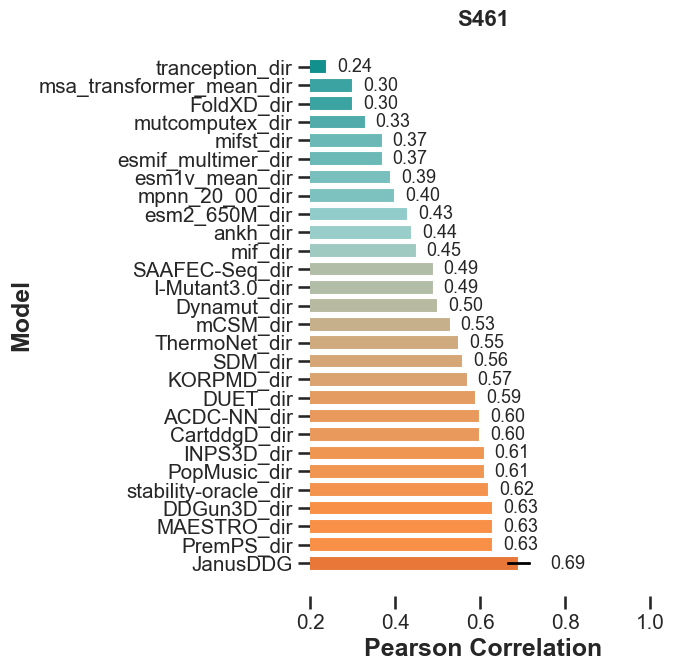

In [108]:
pearson_plot_results(df_pearson, min_error_bar_r, max_error_bar_r, offset_scritta= 0.05,offset_x_min=0.2,dataset_name=DATASET)

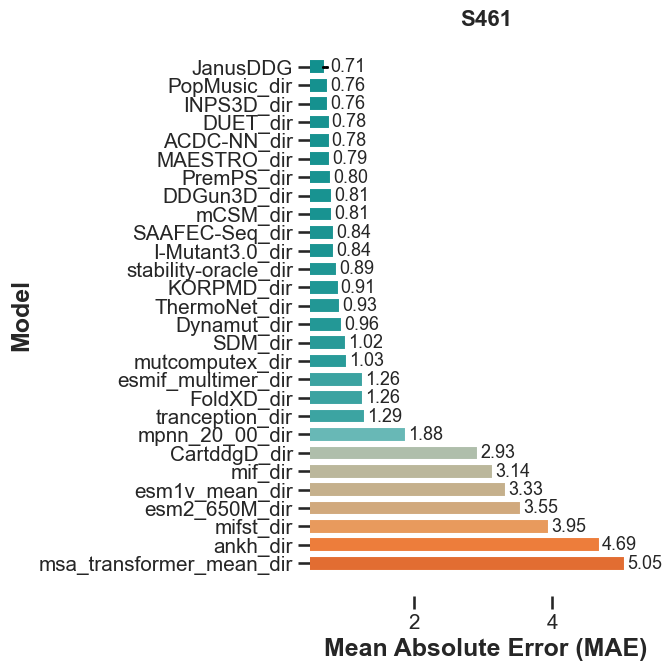

In [113]:
mae_plot_results(df_mae, min_error_bar_mae, max_error_bar_mae, offset_scritta=0.05, offset_x_min=0.5, dataset_name = DATASET)

/tmp/ipykernel_861231/2369693150.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


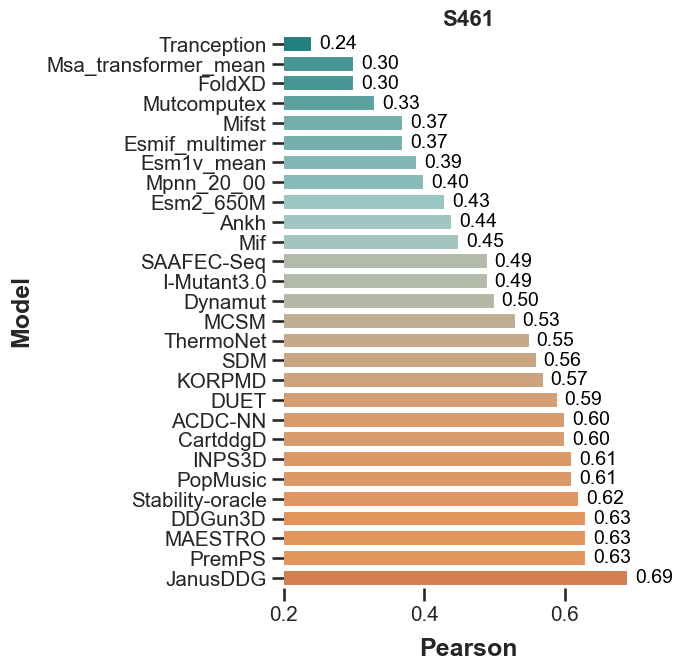

In [172]:
METRIC ='Pearson' # 'MAE'

results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'Model'})
results_df['Model'] = results_df['Model'].map(lambda x:x.split('_dir')[0].upper()[0] + x.split('_dir')[0][1:])
df =pd.DataFrame(results_df)

sns.set(style="ticks", context="talk", font_scale=0.9)
df_plot_pearson = df.sort_values(by=METRIC)
custom_colors = [ '#12908E','#97CECC','#F98F45', '#c4421A']
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=256)
norm = plt.Normalize(df_plot_pearson[METRIC].min(), df_plot_pearson[METRIC].max() * 1.2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

colors = [sm.to_rgba(val) for val in df_plot_pearson[METRIC]]
fig, ax = plt.subplots(figsize=(7, 7))

sns.barplot(
    y="Model",
    x=METRIC,
    data=df_plot_pearson,
    palette=colors,
    ax=ax,
    )

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=14, padding=5, color="black")

ax.set_xlabel(f"{METRIC}", fontsize=18, fontweight="bold", labelpad=10)
ax.set_ylabel("Model", fontsize=18, fontweight="bold", labelpad=10)
ax.set_xlim(0.2)
sns.despine(left=True, bottom=True)
plt.title(f"{DATASET}", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
###################################
#CLASSIFICATION ANALISYS
###################################

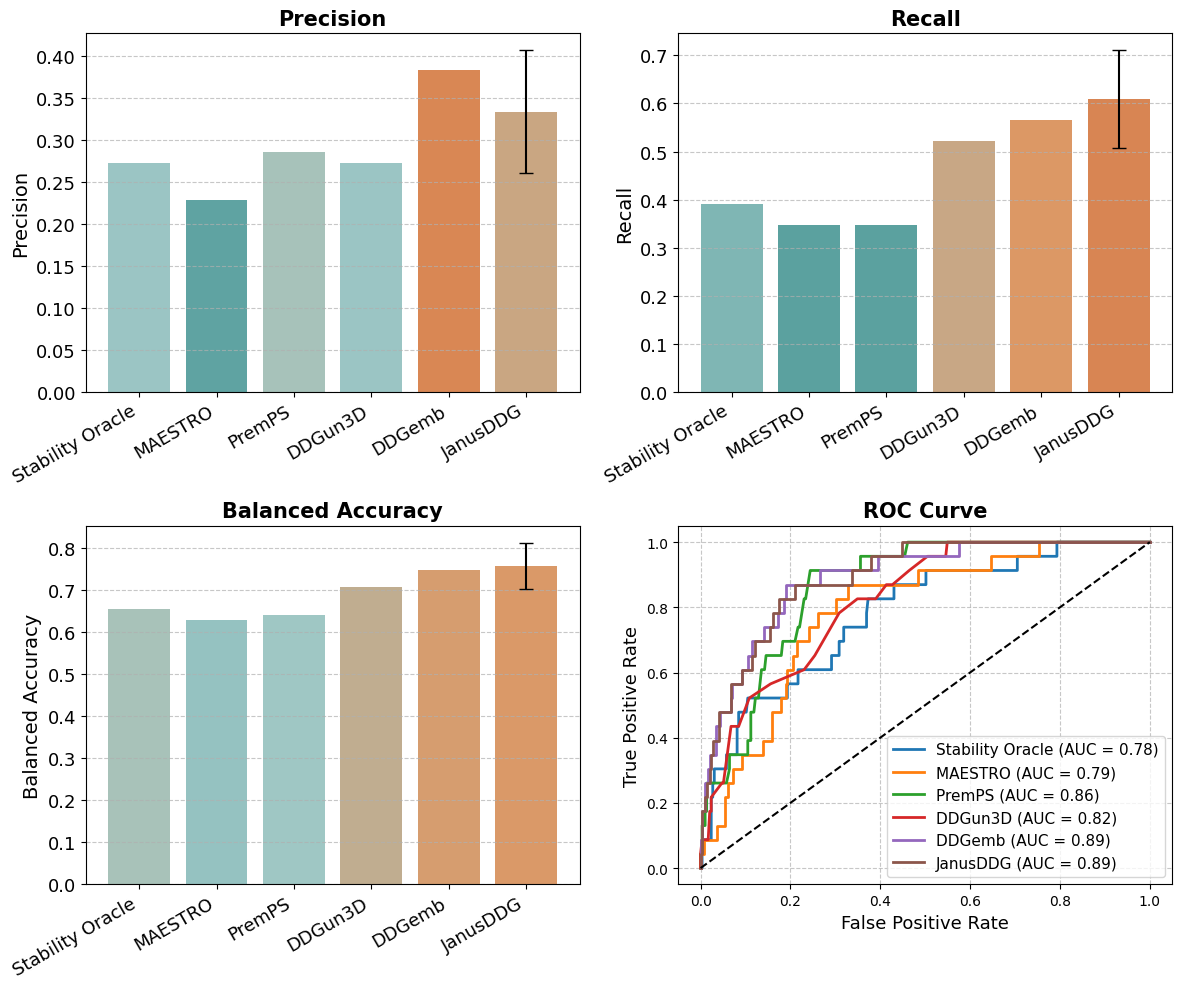

In [8]:
from sklearn.metrics import precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score, f1_score, roc_curve, auc


# error bar functions
def analytic_proportion_se(p, n):
    """Errore standard per proporzione p = k/n"""
    if n == 0:
        return 0.0
    return np.sqrt(p * (1 - p) / n)

def bootstrap_std(y_true, y_pred, metric_fn, n_boot=1000, rng=None):
    """Calcola std bootstrap di una metrica"""
    rng = np.random.default_rng() if rng is None else rng
    n = len(y_true)
    boots = []
    for _ in range(n_boot):
        idx = rng.choice(n, size=n, replace=True)
        boots.append(metric_fn(y_true[idx], y_pred[idx]))
    return np.std(boots, ddof=1)


dataset_classification = pd.read_csv('../results/Result_s461_dir_analysis.csv')
columns_selected = ['stability-oracle_dir', 'MAESTRO_dir', 'PremPS_dir', 'DDGun3D_dir']
target_col = "DDG"
dataset_classification = dataset_classification.loc[:, columns_selected + [target_col]].dropna()
dataset_classification = dataset_classification[(dataset_classification['DDG'] < -0.5) | (dataset_classification['DDG'] > 0.5)]
dataset_classification = dataset_classification.rename(columns={
    'stability-oracle_dir': 'Stability Oracle', 
    'MAESTRO_dir': 'MAESTRO', 
    'PremPS_dir': 'PremPS', 
    'DDGun3D_dir': 'DDGun3D'
})

columns_name = ['Stability Oracle', 'MAESTRO', 'PremPS', 'DDGun3D']
threshold = 0


metrics_dict = {
    'Model': [], 
    'Precision': [], 'Precision_err_low': [], 'Precision_err_high': [],
    'Recall': [], 'Recall_err_low': [], 'Recall_err_high': [],
    'Balanced Accuracy': [], 'Balanced Accuracy_err_low': [], 'Balanced Accuracy_err_high': [],
    'MCC': [], 'F1-score': [], 'AUC': []
}
roc_curves = {}


for model in columns_name:
    model_preds = dataset_classification[model].values
    actual_ddg = dataset_classification['DDG'].values
    
    predicted_labels = model_preds > threshold
    true_labels = actual_ddg > threshold

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)
    balance_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    fpr, tpr, _ = roc_curve(true_labels, model_preds)
    roc_auc = auc(fpr, tpr)
    roc_curves[model] = (fpr, tpr, roc_auc)

    # nessuna barra d’errore per questi modelli
    metrics_dict['Model'].append(model)
    metrics_dict['Precision'].append(precision)
    metrics_dict['Precision_err_low'].append(precision)
    metrics_dict['Precision_err_high'].append(precision)
    metrics_dict['Recall'].append(recall)
    metrics_dict['Recall_err_low'].append(recall)
    metrics_dict['Recall_err_high'].append(recall)
    metrics_dict['Balanced Accuracy'].append(balance_accuracy)
    metrics_dict['Balanced Accuracy_err_low'].append(balance_accuracy)
    metrics_dict['Balanced Accuracy_err_high'].append(balance_accuracy)
    metrics_dict['MCC'].append(mcc)
    metrics_dict['F1-score'].append(f1)
    metrics_dict['AUC'].append(roc_auc)

metrics_df = pd.DataFrame(metrics_dict)

# DDGemb
df_ddgemb = pd.read_excel('../data/s461_with_DDGemb.xlsx', header=1)
df_ddgemb = df_ddgemb[(df_ddgemb['DDG'] < -0.5) | (df_ddgemb['DDG'] > 0.5)]

ddgemb_preds = df_ddgemb["DDG_DDGemb"].values
true_labels_DDGEMB = df_ddgemb["DDG"].values > threshold
predicted_labels_ddgemb = ddgemb_preds > threshold

precision = precision_score(true_labels_DDGEMB, predicted_labels_ddgemb)
recall = recall_score(true_labels_DDGEMB, predicted_labels_ddgemb)
mcc = matthews_corrcoef(true_labels_DDGEMB, predicted_labels_ddgemb)
balance_accuracy = balanced_accuracy_score(true_labels_DDGEMB, predicted_labels_ddgemb)
f1 = f1_score(true_labels_DDGEMB, predicted_labels_ddgemb)

fpr, tpr, _ = roc_curve(true_labels_DDGEMB, ddgemb_preds)
roc_auc = auc(fpr, tpr)
roc_curves['DDGemb'] = (fpr, tpr, roc_auc)

metrics_df.loc[len(metrics_df)] = [
    'DDGemb',
    precision, precision, precision,
    recall, recall, recall,
    balance_accuracy, balance_accuracy, balance_accuracy,
    mcc, f1, roc_auc
]

# JanusDDG con errori
ddgemb_preds = df_ddgemb["DDG_JanusDDG"].values
true_labels_JANUS = df_ddgemb["DDG"].values > threshold
predicted_labels_janus = ddgemb_preds > threshold

precision = precision_score(true_labels_JANUS, predicted_labels_janus)
recall = recall_score(true_labels_JANUS, predicted_labels_janus)
mcc = matthews_corrcoef(true_labels_JANUS, predicted_labels_janus)
balance_accuracy = balanced_accuracy_score(true_labels_JANUS, predicted_labels_janus)
f1 = f1_score(true_labels_JANUS, predicted_labels_janus)
fpr, tpr, _ = roc_curve(true_labels_JANUS, ddgemb_preds)
roc_auc = auc(fpr, tpr)
roc_curves['JanusDDG'] = (fpr, tpr, roc_auc)

# calcolo errori
tp = np.sum((predicted_labels_janus == 1) & (true_labels_JANUS == 1))
fp = np.sum((predicted_labels_janus == 1) & (true_labels_JANUS == 0))
fn = np.sum((predicted_labels_janus == 0) & (true_labels_JANUS == 1))

prec_n = tp + fp
rec_n = tp + fn
prec_se = analytic_proportion_se(precision, prec_n)
rec_se = analytic_proportion_se(recall, rec_n)
ba_se = bootstrap_std(true_labels_JANUS, predicted_labels_janus,
                      balanced_accuracy_score, n_boot=1000)

metrics_df.loc[len(metrics_df)] = [
    'JanusDDG',
    precision, precision - prec_se, precision + prec_se,
    recall, recall - rec_se, recall + rec_se,
    balance_accuracy, balance_accuracy - ba_se, balance_accuracy + ba_se,
    mcc, f1, roc_auc
]

# --- Plot ---
metrics_list = ['Precision', 'Recall', 'Balanced Accuracy']
plt.figure(figsize=(12, 10))

custom_colors = ['#12908E', '#97CECC', '#F98F45', '#c4421A']
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=256)

for i, metric in enumerate(metrics_list, 1):
    plt.subplot(2, 2, i)
    vals = metrics_df[metric].values
    norm = plt.Normalize(metrics_df[metric].min() * 0.8, metrics_df[metric].max() * 1.2)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    colors = [sm.to_rgba(v) for v in vals]

    ax = sns.barplot(data=metrics_df, x='Model', y=metric, hue='Model', legend=False,
                     palette=dict(zip(metrics_df['Model'], colors)), errorbar=None)

    for bar, el, eh, model in zip(ax.patches, 
                                  metrics_df[f"{metric}_err_low"], 
                                  metrics_df[f"{metric}_err_high"], 
                                  metrics_df['Model']):
        if model == 'JanusDDG':
            x = bar.get_x() + bar.get_width()/2
            y = bar.get_height()
            plt.errorbar(x, y, yerr=[[y-el],[eh-y]], fmt='none',
                         ecolor='black', capsize=5)

    plt.xticks(rotation=30, ha='right', fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel('')
    plt.title(f'{metric}', fontsize=15, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# ROC curve
plt.subplot(2, 2, 4)
for model, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
